In [48]:
import numpy as np
import skimage as sk
import skimage.io as skio
from scipy import spatial as sp
import cv2
import math
import matplotlib.pyplot as plt
import skimage.transform as sktr
from scipy.interpolate import griddata
import time
import skimage.draw as skd
from PIL import Image

# Part 1. Defining Correspondences

In [2]:
# points for image

imname = 'macrop2.png'
im = skio.imread(imname)

plt.switch_backend("qtagg")

def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

plt.figure()
plt.imshow(im)

tellme('Select points with mouse, click any key to finish.')

while True:
    pts = []
    pts = np.asarray(plt.ginput(60, timeout=-1))
    if plt.waitforbuttonpress():
        break

print(pts)

Select points with mouse, click any key to finish.


In [260]:
np.save('ma_pts.npy', pts)

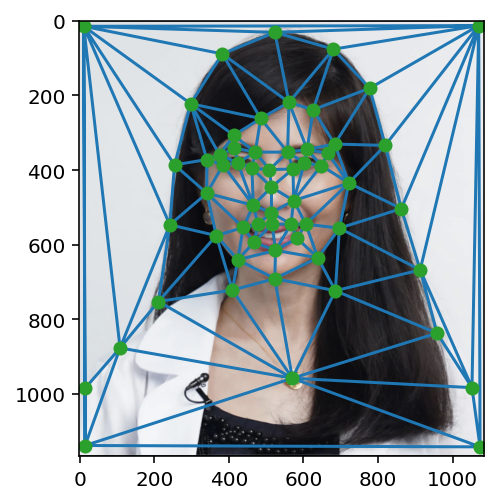

In [363]:
pts = np.load('ma_pts.npy')
tri_ma = sp.Delaunay(pts)
plt.figure()
imname = 'macrop2.png'
imma = skio.imread(imname)
plt.imshow(imma)
plt.triplot(pts[:,0], pts[:,1], tri_ma.simplices)
plt.plot(pts[:,0], pts[:,1], 'o')
plt.show()
plt.savefig('ma_delaunay.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

Select points with mouse, click any key to finish.
[[  11.15591398    9.68953405]
 [1069.90143369    7.74688172]
 [  11.15591398 1146.14114695]
 [1073.78673835 1151.96910394]
 [ 467.67921147  926.62143369]
 [ 512.36021505   87.39562724]
 [ 358.890681    120.42071685]
 [ 281.18458781  236.97985663]
 [ 244.27419355  388.50673835]
 [ 209.30645161  545.86157706]
 [ 193.76523297  732.35620072]
 [ 116.05913978  864.45655914]
 [  32.52508961  986.84365591]
 [ 665.8297491   135.96193548]
 [ 735.76523297  229.20924731]
 [ 768.79032258  328.28451613]
 [ 803.75806452  507.00853047]
 [ 852.32437276  652.7074552 ]
 [ 931.97311828  788.69311828]
 [1048.53225806  944.10530466]
 [ 384.14516129  328.28451613]
 [ 426.88351254  316.62860215]
 [ 473.50716846  336.05512545]
 [ 578.41039427  355.48164875]
 [ 626.97670251  336.05512545]
 [ 669.71505376  357.42430108]
 [ 403.57168459  369.08021505]
 [ 434.65412186  369.08021505]
 [ 469.6218638   384.62143369]
 [ 574.52508961  402.10530466]
 [ 605.60752688  39

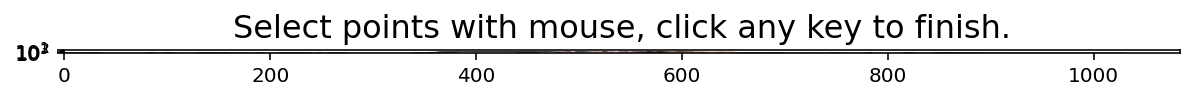

In [262]:
# points for image

imname = 'camcrop.jpg'
im = skio.imread(imname)

plt.switch_backend("qtagg")

def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

plt.figure()
plt.imshow(im)

tellme('Select points with mouse, click any key to finish.')

while True:
    cam_pts = []
    cam_pts = np.asarray(plt.ginput(60, timeout=-1))
    if plt.waitforbuttonpress():
        break

print(cam_pts)

In [263]:
np.save('cam_pts.npy', cam_pts)

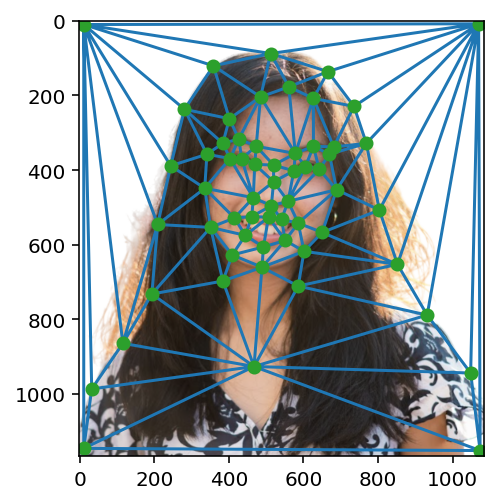

In [364]:
cam_pts = np.load('cam_pts.npy')
tri = sp.Delaunay(cam_pts)
plt.figure()
imname = 'camcrop.jpg'
im = skio.imread(imname)
plt.imshow(im)
plt.triplot(cam_pts[:,0], cam_pts[:,1], tri.simplices)
plt.plot(cam_pts[:,0], cam_pts[:,1], 'o')
plt.show()
plt.savefig('cam_delaunay.png', dpi=300, bbox_inches='tight')  # Adjust filename and parameters as needed

# Part 2. Computing the "Mid-way Face"

Compute the Average Shape

In [365]:
avg_shape = (cam_pts + pts) / 2
np.save('avg_pts.npy', avg_shape)
tri_avg = sp.Delaunay(avg_shape)

In [366]:
# compute affine transformation matrix: returns matrix A where A * p = q
# p = 6x1 matrix of the x1, y1 then x2, y2 of a triangle 
# q = 6x1 matrix of the x1, y1 then x2, y2 of the corresponding NEW AVERAGE triangle
# returns 3x3 matrix A that is supposed to be multiplied by the original image to get the new image

def computeAffine(tri1_pts, tri2_pts):
    A = np.zeros((6, 6))
    b = np.zeros((6, 1))
    for i in range(3):
        A[2*i] = [tri1_pts[i][0], tri1_pts[i][1], 1, 0, 0, 0]
        A[2*i+1] = [0, 0, 0, tri1_pts[i][0], tri1_pts[i][1], 1]
        b = [tri2_pts[0][0], tri2_pts[0][1], tri2_pts[1][0],tri2_pts[1][1], tri2_pts[2][0], tri2_pts[2][1]]
    x = np.linalg.inv(A) @ b
    ret = np.array([[x[0], x[1], x[2]], [x[3], x[4], x[5]], [0, 0, 1]])
    return ret.reshape(3, 3)

In [367]:
def warp_from_avg(im1, im1_pts, avg_pts):
    if len(im1.shape) > 2:
        im1 = im1[:, :, :3]
    if len(im1.shape) == 2:  # Grayscale
        im1 = im1[:, :, np.newaxis]
    endresult = np.zeros(im1.shape) * 255
    pts_input = np.array([[x, y] for x in range(im1.shape[0]) for y in range(im1.shape[1])])
    vals = im1.reshape(-1, im1.shape[2]) 

    tri_avg = sp.Delaunay(avg_pts)

    mid_triangles = tri_avg.simplices
    for triangle in mid_triangles:
        avg_coords = avg_pts[triangle]
        im1_coords = im1_pts[triangle]

        mat = computeAffine(im1_coords, avg_coords)

        inv = np.linalg.inv(mat)
        
        points = sk.draw.polygon(avg_coords[:, 0], avg_coords[:, 1])
        points_mat = np.vstack((points[0], points[1], np.ones(points[0].shape))).T
        
        og_pts = (points_mat @ inv.T)[:, :2]
        og_pts[:, [0, 1]] = og_pts[:, [1, 0]]

        interpolate_colors = griddata(pts_input, vals, og_pts, method='nearest', fill_value=0)

        points_y, points_x = points[0], points[1]  
        endresult[points_x, points_y] = interpolate_colors
    
    endresult = endresult.astype(np.uint8)
    return endresult



Lossy conversion from float64 to uint8. Range [0.0, 249.5]. Convert image to uint8 prior to saving to suppress this warning.


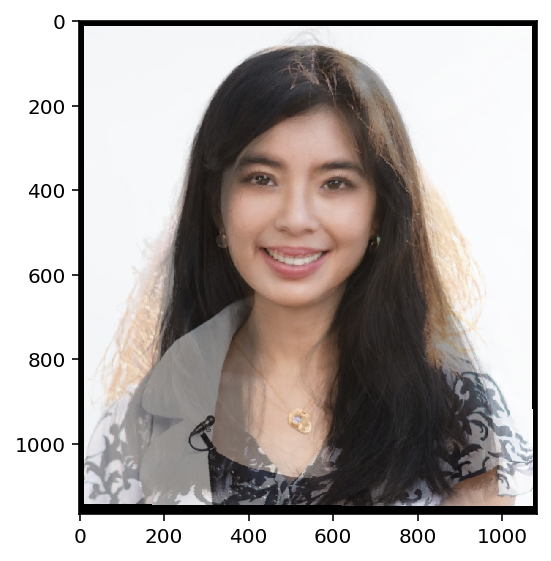

In [381]:
ma_pts = np.load('ma_pts.npy')
cam_pts = np.load('cam_pts.npy')

imname = 'macrop2.png'
imma = skio.imread(imname)

imname = 'camcrop.jpg'
imcam = skio.imread(imname)

endres1 = warp_from_avg(imma, ma_pts, avg_shape)
skio.imsave('endres1.png', endres1)
endres2 = warp_from_avg(imcam, cam_pts, avg_shape)
skio.imsave('endres2.png', endres2)

def cross_dissolve(im1, im2, frac):
    return (1 - frac) * im1 + frac * im2

res = cross_dissolve(endres1, endres2, 0.5)

skio.imsave('camma_avg.png', res)

loaded_image = skio.imread('camma_avg.png')

skio.imshow(loaded_image)
skio.show()

# Part 3. The Morph Sequence

In [359]:
def morph(im1, im2, im1_pts, im2_pts, warp_frac, dissolve_frac):
    avg_shape = (1 - warp_frac) * im1_pts + (warp_frac * im2_pts)
    endres1 = warp_from_avg(im1, im1_pts, avg_shape)
    endres2 = warp_from_avg(im2, im2_pts, avg_shape)
    res = cross_dissolve(endres1, endres2, dissolve_frac)
    return res

Lossy conversion from float64 to uint8. Range [0.0, 249.5]. Convert image to uint8 prior to saving to suppress this warning.


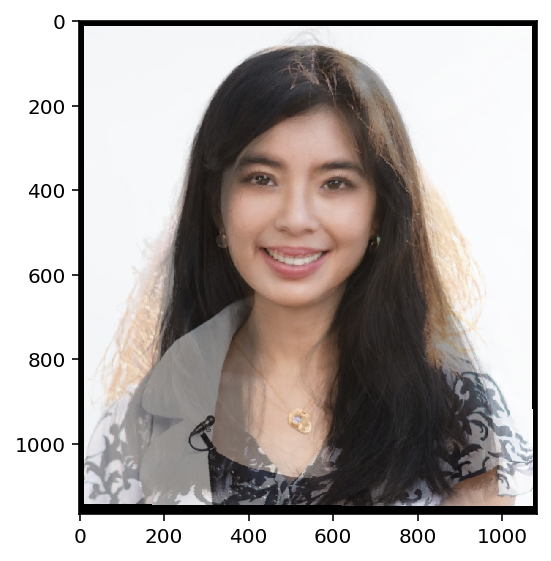

In [360]:
morphed = morph(imma, imcam, pts, cam_pts, 0.5, 0.5)
skio.imsave('morphed_test.png', morphed)

# Load the saved image
morphed_test = skio.imread('morphed_test.png')

# Display the image
skio.imshow(morphed_test)
skio.show()

In [28]:
frames = []
num_frames = 50
for i in range(num_frames):
    morphed = morph(imma, imcam, pts, cam_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('morphed_w_interp.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

# Part 4: The "Mean face" of a population

Compute the average points of the smiling faces

In [147]:
# parsing through 1b.pts file to instantiate points

points = []
with open('pop_pts/1b.pts', 'r') as f:
    # Skip version & count line (first two lines)
    lines = f.readlines()[2:]  
    for line in lines:
        line = line.strip()  # removing whitespace!
        if line and line not in ('{', '}'):  # ignoring empty lines and braces
            points.append(list(map(float, line.split())))

test_pts = np.array(points)

In [162]:
all_points = []

for i in range(1, 201):
    with open(f'pop_pts/{i}b.pts', 'r') as f:
        lines = f.readlines()[2:]  
        pts = []
        for line in lines:
            line = line.strip()  
            if line and line not in ('{', '}'): 
                pts.append(list(map(float, line.split()))) 
        pts.append([5, 5])
        pts.append([245, 5])
        pts.append([5, 295])
        pts.append([245, 295])

    all_points.append([np.array(pts)])

# concatenate all arrays into single array
all_points = np.concatenate(all_points)

np.save('allpop_pts.npy', all_points)

In [163]:
average_points = np.mean(all_points, axis=0)
np.save('avgpop_pts.npy', average_points)

Morphing Faces to the Average Shape

In [371]:
all_points = np.load('allpop_pts.npy')
avg_pts = np.load('avgpop_pts.npy')

ims = []
for i in range(1, 201):
    imname = f'normalized/{i}b.jpg'
    jit_im = skio.imread(imname)
    jit_pts = all_points[i - 1]
    res = warp_from_avg(jit_im, jit_pts, avg_pts)
    ims.append(res)
    if i in [9, 51, 123, 187]:
        skio.imsave(f'averaged_imgs/pop_mid_{i}.png', res)
        

Finding the Average Face!

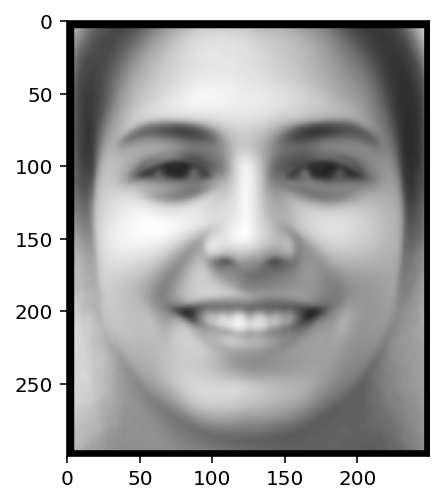

In [249]:
# averaging all the images

ims_array = np.array(ims)
average_image = np.mean(ims_array, axis=0)

# clip values and convert to uint8
average_image = np.clip(average_image, 0, 255).astype(np.uint8)

plt.imshow(average_image, cmap = "gray")

skio.imsave('pop_avg.png', average_image)

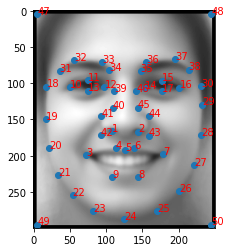

In [173]:
plt.imshow(average_image, cmap = "gray")
plt.plot(avg_pts[:, 0], avg_pts[:, 1], 'o')

# label each point from 1 - 50:
for i in range(50):
    plt.text(avg_pts[i, 0], avg_pts[i, 1], str(i + 1), color='red')
    
plt.savefig('popavg_pts.png', dpi=300, bbox_inches='tight')  

Select points with mouse, click any key to finish.
[[105.18544387 173.01529614]
 [139.77267609 176.23271309]
 [ 64.96773199 200.36334022]
 [105.98979811 195.53721479]
 [116.4464032  196.34156903]
 [131.72913371 197.14592326]
 [168.72942864 204.3851114 ]
 [136.55525914 242.18976057]
 [100.35931844 243.79846905]
 [ 48.88064724 103.8408317 ]
 [ 72.20692013  97.4059978 ]
 [ 91.51142183 110.2756656 ]
 [ 70.59821165 111.88437408]
 [155.85976084 114.29743679]
 [175.96861678 101.42776899]
 [197.68618119 110.2756656 ]
 [177.57732525 115.90614527]
 [ 14.29341502 102.23212323]
 [ 10.27164383 145.66725206]
 [ 10.27164383 185.0806097 ]
 [ 19.92389468 218.86348768]
 [ 45.66323029 247.82024023]
 [ 72.20692013 272.7552216 ]
 [116.4464032  282.40747245]
 [157.46846931 271.14651312]
 [186.42522187 244.60282328]
 [206.53407781 218.86348768]
 [218.59939137 184.27625546]
 [226.64293375 132.79758426]
 [225.03422527 105.44954018]
 [ 36.01097944  78.1014961 ]
 [ 51.29370995  67.64489101]
 [ 77.83739979  70.05

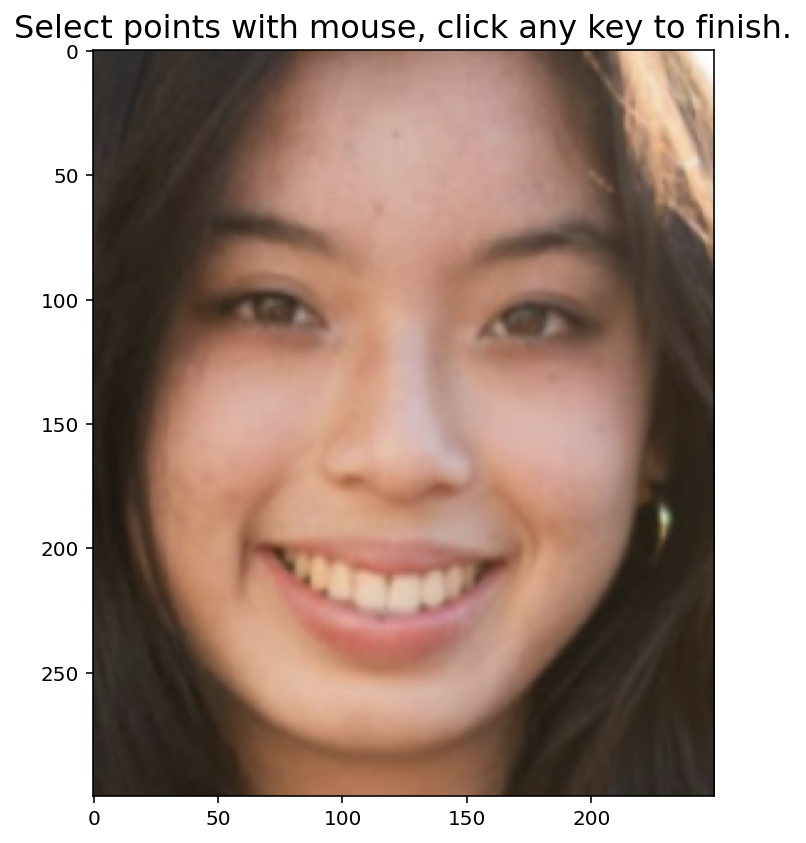

In [202]:
# PLOTTING correspondence points for MY face according to the dataset

imname = 'cam_croplots.png'
im = skio.imread(imname)

plt.switch_backend("qtagg")

def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

plt.figure()
plt.imshow(im)

tellme('Select points with mouse, click any key to finish.')

while True:
    camcrop_pts = []
    camcrop_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

print(camcrop_pts)

In [203]:
np.save('cam_cropped.npy', camcrop_pts)

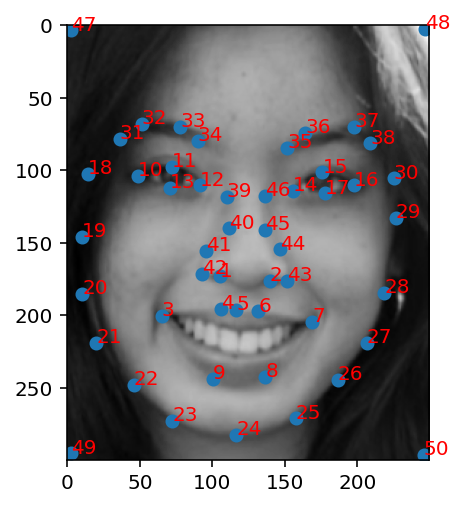

In [377]:
camcrop = skio.imread('cam_croplots.png')
camcrop = cv2.cvtColor(camcrop, cv2.COLOR_BGR2GRAY)
plt.imshow(camcrop, cmap = "gray")
plt.plot(camcrop_pts[:, 0], camcrop_pts[:, 1], 'o')

# label each point 
for i in range(50):
    plt.text(camcrop_pts[i, 0], camcrop_pts[i, 1], str(i + 1), color='red')
    
plt.savefig('camcrop_pts.png', dpi=300, bbox_inches='tight')  

My face warped to average geometry


In [372]:
avg_pts = np.load('avgpop_pts.npy')
me_warped = warp_from_avg(camcrop, camcrop_pts, avg_pts)
skio.imsave(f'me_warped.png', me_warped)

Average face warped to my geometry

In [373]:
camcrop_pts = np.load('cam_cropped.npy')
avg_warped = warp_from_avg(average_image, avg_pts, camcrop_pts)
skio.imsave(f'avg_warped.png', avg_warped)

# Part 5. Caricatures: Extrapolating from the mean

In [380]:
camcrop = skio.imread('cam_croplots.png')
camcrop = cv2.cvtColor(camcrop, cv2.COLOR_BGR2GRAY)

In [379]:
for i in [-1, -0.5, 0.5, 1.5, 2.0]:
    both_morphed = morph(camcrop, average_image, camcrop_pts, avg_pts, i, 0.5)
    skio.imsave(f'car{i}.png', both_morphed)

Lossy conversion from float64 to uint8. Range [0.0, 179.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 177.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 177.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 178.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 178.5]. Convert image to uint8 prior to saving to suppress this warning.


# Part 6: Bells and Whistles

In [ ]:
# next time, I'll probably run code similar to this:

for i in range(1, 13):
    cam = skio.imread(f'bells/cam{i}.png')
    plt.figure()
    plt.imshow(cam)

    tellme('Select points with mouse, click any key to finish.')
    while True:
        cam_pts = []
        cam_pts = np.asarray(plt.ginput(50, timeout=-1))
        if plt.waitforbuttonpress():
            break

    np.save(f'cam{i}.npy', cam_pts)
    morphed = morph(cam{i - 1}, cam{i}, cam{i - 1}_pts, cam{i}_pts, 0.5, 0.5)

    skio.imsave(f'cam{i - 1}{i}_morph.png', morphed)

    frames = []
    num_frames = 40
    for i in range(num_frames):
        morphed = morph(cam{i - 1}, cam{i}, cam{i - 1}_pts, cam{i}_pts, i / num_frames, i / num_frames) 
        frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam78_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

*Disclaimer: I could have combined this all into one function and run it one time (would have been much cleaner), but I broke it up individually in case I messed up on selecting points + to adjust images if I wasn't happy with the in-between result*

For each image, I found the correspondence points and created a gif based on the morph sequence from the previous image to the current image.

Select points with mouse, click any key to finish.


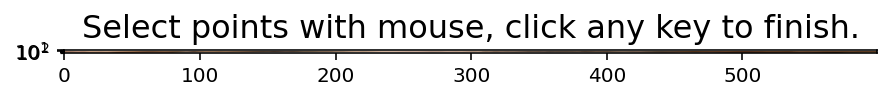

In [306]:
dino = skio.imread('bells/cam1.png')
plt.switch_backend("qtagg")

def tellme(s):
    print(s)
    plt.title(s, fontsize=16)
    plt.draw()

plt.figure()
plt.imshow(dino)

tellme('Select points with mouse, click any key to finish.')

while True:
    cam1_pts = []
    cam1_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam1.npy', cam1_pts)

Select points with mouse, click any key to finish.


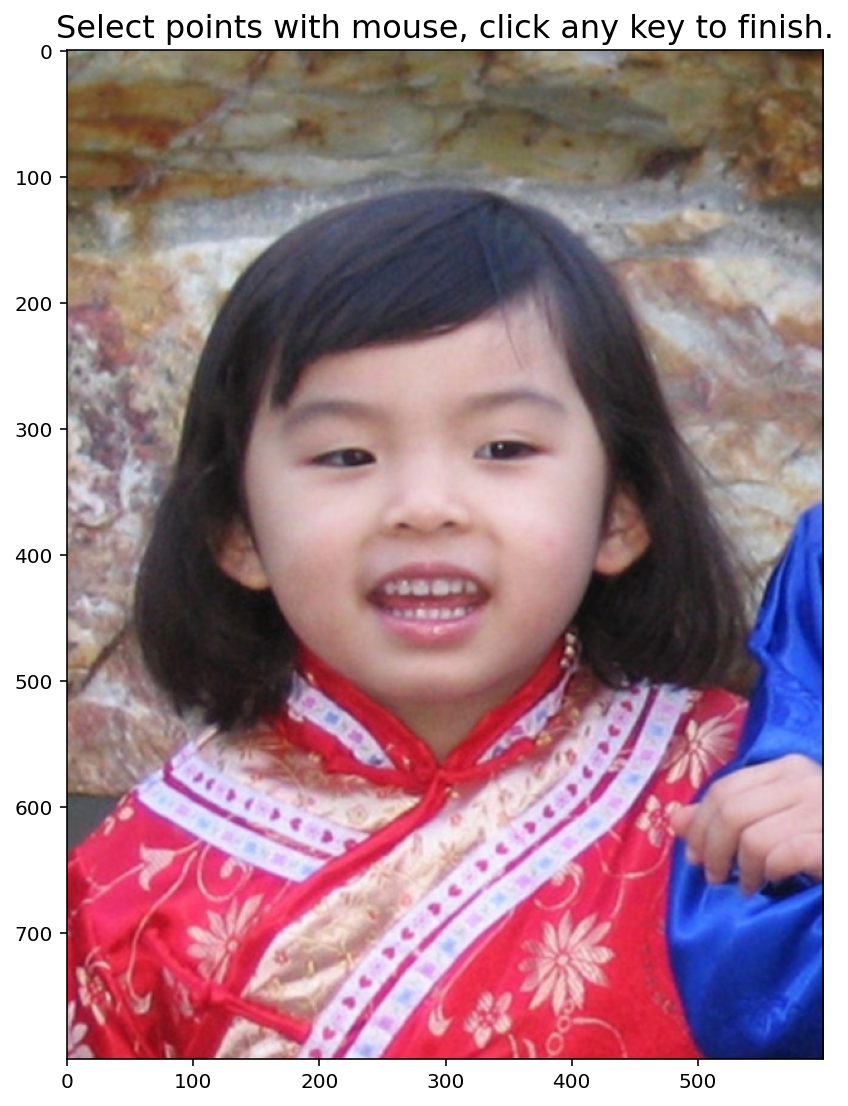

In [307]:
cam2 = skio.imread('bells/cam2.png')
plt.figure()
plt.imshow(cam2)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam2_pts = []
    cam2_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam2.npy', cam2_pts)

In [308]:
cam12_morph = morph(dino, cam2, cam1_pts, cam2_pts, 0.5, 0.5)
skio.imsave(f'cam12_morph.png', cam12_morph)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [309]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(dino, cam2, cam1_pts, cam2_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam12_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


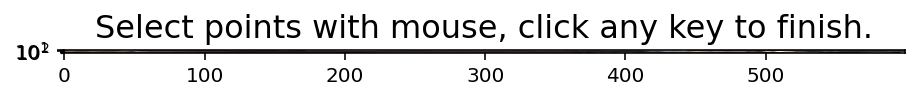

In [310]:
cam3 = skio.imread('bells/cam3.png')
plt.figure()
plt.imshow(cam3)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam3_pts = []
    cam3_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam3.npy', cam3_pts)

In [312]:
cam23_morph = morph(cam2, cam3, cam2_pts, cam3_pts, tri, 0.5, 0.5)
skio.imsave(f'cam23_morph.png', cam23_morph)

Lossy conversion from float64 to uint8. Range [0.0, 240.5]. Convert image to uint8 prior to saving to suppress this warning.


In [313]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam2, cam3, cam2_pts, cam3_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam23_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


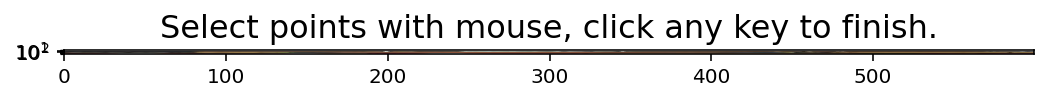

In [314]:
cam4 = skio.imread('bells/cam4.png')
plt.figure()
plt.imshow(cam4)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam4_pts = []
    cam4_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam4.npy', cam4_pts)

In [315]:
cam34_morph = morph(cam3, cam4, cam3_pts, cam4_pts, 0.5, 0.5)
skio.imsave(f'cam34_morph.png', cam34_morph)

Lossy conversion from float64 to uint8. Range [0.0, 239.5]. Convert image to uint8 prior to saving to suppress this warning.


In [316]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam3, cam4, cam3_pts, cam4_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam34_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


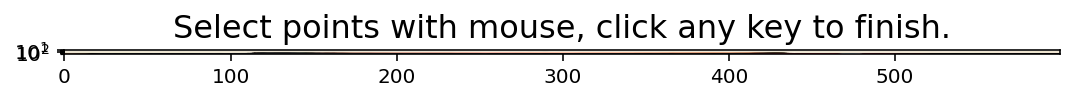

In [317]:
cam5 = skio.imread('bells/cam5.png')
plt.figure()
plt.imshow(cam5)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam5_pts = []
    cam5_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam5.npy', cam5_pts)

In [318]:
cam45_morph = morph(cam4, cam5, cam4_pts, cam5_pts, 0.5, 0.5)
skio.imsave(f'cam45_morph.png', cam45_morph)

Lossy conversion from float64 to uint8. Range [0.0, 246.5]. Convert image to uint8 prior to saving to suppress this warning.


In [319]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam4, cam5, cam4_pts, cam5_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam45_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


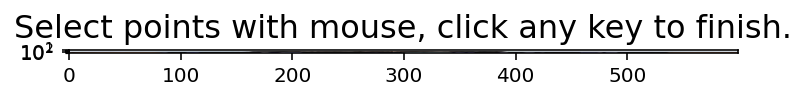

In [321]:
cam6 = skio.imread('bells/cam6.png')
plt.figure()
plt.imshow(cam6)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam6_pts = []
    cam6_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam6.npy', cam6_pts)

In [322]:
cam56_morph = morph(cam5, cam6, cam5_pts, cam6_pts, 0.5, 0.5)
skio.imsave(f'cam56_morph.png', cam56_morph)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [323]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam5, cam6, cam5_pts, cam6_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam56_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


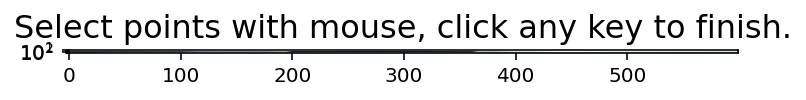

In [325]:
cam7 = skio.imread('bells/cam7.png')
plt.figure()
plt.imshow(cam7)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam7_pts = []
    cam7_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam7.npy', cam7_pts)

In [333]:
cam6_pts = np.load('cam6.npy')
cam67_morph = morph(cam6, cam7, cam6_pts, cam7_pts, 0.5, 0.5)
skio.imsave(f'cam67_morph.png', cam67_morph)

Lossy conversion from float64 to uint8. Range [0.0, 247.0]. Convert image to uint8 prior to saving to suppress this warning.


In [334]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam6, cam7, cam6_pts, cam7_pts, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam67_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


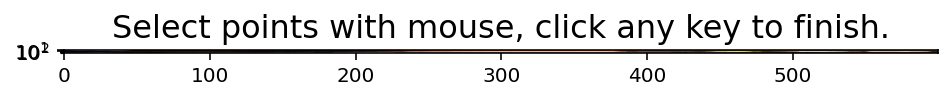

In [335]:
cam8 = skio.imread('bells/cam8.png')
plt.figure()
plt.imshow(cam8)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam8_pts = []
    cam8_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam8.npy', cam8_pts)

In [336]:
cam78_morph = morph(cam7, cam8, cam7_pts, cam8_pts, tri, 0.5, 0.5)
skio.imsave(f'cam78_morph.png', cam78_morph)

Lossy conversion from float64 to uint8. Range [0.0, 246.5]. Convert image to uint8 prior to saving to suppress this warning.


In [337]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam7, cam8, cam7_pts, cam8_pts, tri, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam78_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


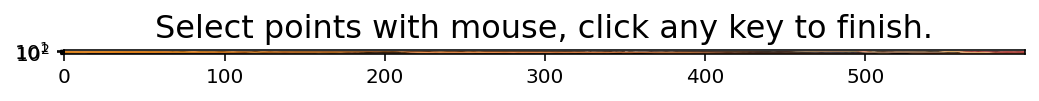

In [340]:
cam9 = skio.imread('bells/cam9.png')
plt.figure()
plt.imshow(cam9)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam9_pts = []
    cam9_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam9.npy', cam9_pts)

In [342]:
cam8_pts = np.load('cam8.npy')
cam89_morph = morph(cam8, cam9, cam8_pts, cam9_pts, tri, 0.5, 0.5)
skio.imsave(f'cam89_morph.png', cam89_morph)

Lossy conversion from float64 to uint8. Range [0.0, 251.5]. Convert image to uint8 prior to saving to suppress this warning.


In [343]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam8, cam9, cam8_pts, cam9_pts, tri, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam89_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


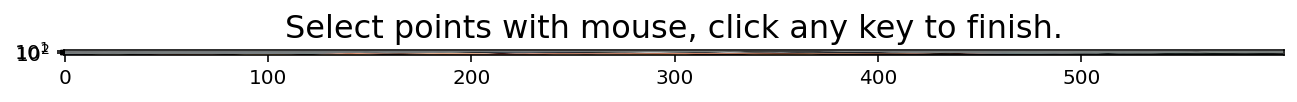

In [344]:
cam10 = skio.imread('bells/cam10.png')
plt.figure()
plt.imshow(cam10)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam10_pts = []
    cam10_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam10.npy', cam10_pts)

In [345]:
cam910_morph = morph(cam9, cam10, cam9_pts, cam10_pts, tri, 0.5, 0.5)
skio.imsave(f'cam910_morph.png', cam910_morph)

Lossy conversion from float64 to uint8. Range [0.0, 249.5]. Convert image to uint8 prior to saving to suppress this warning.


In [347]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam9, cam10, cam9_pts, cam10_pts, tri, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam910_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


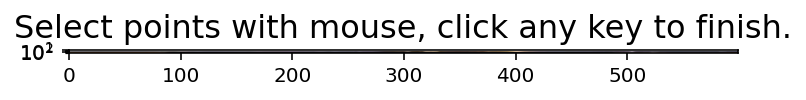

In [348]:
cam11 = skio.imread('bells/cam11.png')
plt.figure()
plt.imshow(cam11)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam11_pts = []
    cam11_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam11.npy', cam11_pts)

In [349]:
cam1011_morph = morph(cam10, cam11, cam10_pts, cam11_pts, tri, 0.5, 0.5)
skio.imsave(f'cam1011_morph.png', cam1011_morph)

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


In [350]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam10, cam11, cam10_pts, cam11_pts, tri, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam1011_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

Select points with mouse, click any key to finish.


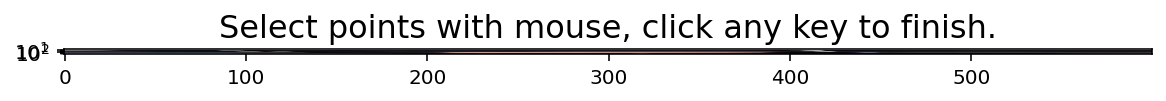

In [351]:
cam12 = skio.imread('bells/cam12.png')
plt.figure()
plt.imshow(cam12)

tellme('Select points with mouse, click any key to finish.')
while True:
    cam12_pts = []
    cam12_pts = np.asarray(plt.ginput(50, timeout=-1))
    if plt.waitforbuttonpress():
        break

np.save('cam12.npy', cam12_pts)

In [352]:
cam1112_morph = morph(cam11, cam12, cam11_pts, cam12_pts, tri, 0.5, 0.5)
skio.imsave(f'cam1112_morph.png', cam1112_morph)

Lossy conversion from float64 to uint8. Range [0.0, 218.0]. Convert image to uint8 prior to saving to suppress this warning.


In [353]:
frames = []
num_frames = 40
for i in range(num_frames):
    morphed = morph(cam11, cam12, cam11_pts, cam12_pts, tri, i / num_frames, i / num_frames) 
    frames.append(Image.fromarray(morphed.astype(np.uint8)))
    
    frames[0].save('cam1112_morph.gif', save_all=True, append_images=frames[1:], duration=50, loop=1)

In [355]:
# combine ALL GIFS to create ONE:

gif_frames = []
for i in range(1, 12):
    gif = Image.open(f'cam{i}{i + 1}_morph.gif')
    gif_frames.append(gif)

gif_frames[0].save('all_morph.gif', save_all=True, append_images=gif_frames[1:], duration=50, loop=1)